# Uncertainty Engine SDK basic usage - workflows

This notebook goes through some of the basic functionality of the SDK. It uses the `Add` node to demonstrate how workflows can be constructed and executed.

Start by importing and initializing the `Client` (for more details about the client see the `demo_node.ipynb` example). 

In [ ]:
from uncertainty_engine.client import Client

client = Client(
    email="<you-email>",  # Note: There must be token associated with this email.
    deployment="<a-deployment-url>",
)

## Constructing a graph

Next import and initialize the `Graph` object.

In [2]:
from uncertainty_engine.graph import Graph

graph = Graph()

This `Graph` object allows you to connect sets of nodes together. Which, along with the definition of any inputs external to the graph, can be executed as a workflow.  

Next we can define our starting node. We will use `Add` nodes throughout this example as they're the simplest to understand.

In [3]:
from uncertainty_engine.nodes.demo import Add

add_1 = Add(rhs=1, lhs=2)

This node could be executed by itself (see `demo_node.ipynb`), but we want to add it to our `graph`.

In [4]:
graph.add_node(add_1, label="First Add")

Now lets add an additional `Add` node but make one its inputs the result of the first addition. To do this we will add the `Add` node class to the graph rather than an instance.

In [5]:
graph.add_node(Add, label="Second Add")

Then we will define a connection, an edge, between these two nodes.

In [6]:
graph.add_edge(
    source="First Add",
    target="Second Add",
    source_key="ans",  # This output key can be found in the node information - see demo_node.ipynb
    target_key="lhs"
)

Finally we will add an additional external input to our second addition node. To do this we label the input as follows `"<node-label>_<input-name>"`.

In [7]:
graph.add_input("Second Add_rhs", 3)
graph.add_edge(
    source=graph.external_input_id,
    target="Second Add",
    source_key="Second Add_rhs",
    target_key="rhs"
)

Before executing the workflow we can visualize the graph we have created.

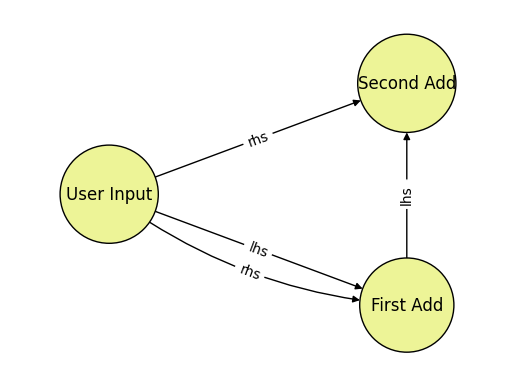

In [8]:
from uncertainty_engine.visualization import visualize_graph

visualize_graph(graph)

We can see in tha above visualization that the external inputs to the graph appear as their own "node" with label "User Input". We can also see that all connections between nodes are labelled with the input variable of the target node. These visualizations can be useful to understand the graphs you're constructing as they grow in complexity.

For example, we can add a final `Add` node, connected to our other `Add` nodes, and visually confirm it has been added to the graph as expected.

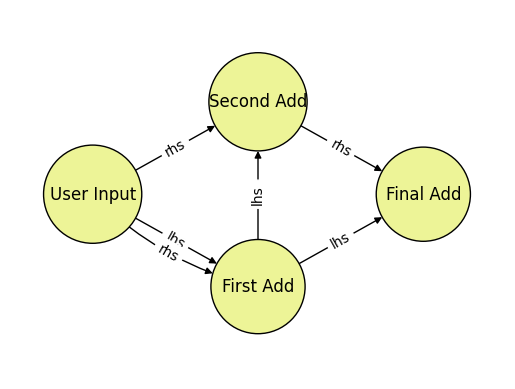

In [9]:
graph.add_node(Add, label="Final Add")
graph.add_edge("First Add", "Final Add", "ans", "lhs")
graph.add_edge("Second Add", "Final Add", "ans", "rhs")

visualize_graph(graph)

## Executing a workflow

In the Uncertainty Engine, workflows are treated like any other node. This allows you to construct workflows and then use them like nodes in new workflows. So to execute our graph in a workflow we first import and initialize the `Workflow` node.

In [10]:
from uncertainty_engine.nodes.workflow import Workflow

workflow = Workflow(
    graph=graph.nodes,
    input=graph.external_input,
    external_input_id=graph.external_input_id,
    requested_output={
        "First Add": ("First Add", "ans"),
        "Second Add": ("Second Add", "ans"),
        "Final Add": ("Final Add", "ans"),
        }
    )

In the above cell we have defined our `requested_output` as the output of all of our addition nodes. However, if you don't have to request the result from all of your nodes. This can be very useful when debugging complex or costly workflows.

Now execute the workflow like any other node.

(We use `pprint` to make the data display a bit nicer)

In [11]:
from pprint import pprint

response = client.run_node(workflow)
pprint(response)

{'output': {'Final Add': 9, 'First Add': 3, 'Second Add': 6},
 'status': 'SUCCESS',
 'task_id': '0e1c66f3-862f-40e2-b3d3-b8a6669ef296'}


Checkout our other example notebooks to see example execution of some more complex nodes.